In [17]:
import h5py
import numpy as  np
import matplotlib.pyplot as plt
from source import helper
plt.rcParams["figure.figsize"] = (20,5)
plt.rcParams["image.interpolation"] = 'none'
import tensorflow as tf


In [18]:
H5_FILENAME = 'final_dataset'
loaded_file = h5py.File('data/'+ H5_FILENAME + '.h5','r')

In [19]:
path_model = tf.keras.models.load_model('data/models/model_8.h5')

In [20]:
keys = list(loaded_file.keys())
_ = [print(f'{i}: {k}') for i,k in enumerate(keys)]

0: background
1: bartek
2: kuba
3: oddychacz_2m_o0_s100
4: oddychacz_2m_o30_s0
5: oddychacz_2m_o30_s100
6: oddychacz_3m_o0_s100
7: oddychacz_3m_o30_s0
8: oddychacz_3m_o30_s100
9: oddychacz_4m_o0_s100
10: oddychacz_4m_o30_s0
11: oddychacz_4m_o30_s100
12: oskar
13: rafal
14: randomowe_chodzonko_bartek
15: randomowe_chodzonko_kuba
16: randomowe_chodzonko_oskar
17: randomowe_chodzonko_rafal
18: samochod
19: samples
20: wiatrak_2m
21: wiatrak_3m
22: wiatrak_4m
23: wiatrak_foliarz_2m
24: wiatrak_foliarz_3m
25: wiatrak_foliarz_4m


In [21]:
file = 13

In [22]:
background = loaded_file['background']
distances = [1,2,5,10,20,50]
max_depth = 50

frames = loaded_file[keys[file]]
frames = helper.subtract_background(background, frames)
spects,y = helper.gen_n_diff_spect(frames, distances=distances)
spects = np.array(spects)
spects = spects[:,:50,:]


test_set=[]
back = 10
spects = np.array(spects)

normalized_spects = [helper.normalize(s) for s in spects]
normalized_spects = np.array(normalized_spects)

for i in range(spects.shape[-1]-back):
    window = normalized_spects[:,:,i:i+back]
    test_set.append(window)

test_set = np.array(test_set)
test_set  = np.expand_dims(test_set, axis=-1)
path_pred = path_model.predict(test_set)

pred11 = helper.get_argmaxed_spectrogram(path_pred.T)
Y_pos = np.argmax(path_pred, axis=1)


283/283 [==============================] - 1s 4ms/step


In [23]:
window_size = (15,15)
windows = []
x_windows = []
y_windows = []
for x,y in enumerate(Y_pos):
    y_dim = window_size[1] // 2
    x_dim = window_size[0]
    window = normalized_spects[:,
                                y-y_dim:y+y_dim+1,
                                x-x_dim:x]
    if window[0].shape == window_size:
        windows.append(window)
        x_windows.append(x)
        y_windows.append(y)



In [24]:
windows = np.array(windows)
x_windows = np.array(x_windows)
y_windows = np.array(y_windows)

In [25]:
windows.shape


(6631, 6, 15, 15)

In [26]:
classification_model = tf.keras.models.load_model('data/models/class_conv3d_(15,15).h5')

In [27]:
pred = classification_model.predict(windows)

208/208 [==============================] - 1s 3ms/step


In [28]:
colors = {0: (255,0,0),
          1: (0,255,0),
          2: (0,0,255),
          3: (255,255,0),
          4: (255,0,255),}

In [29]:
shape = list(Y_pos.shape)
shape.append(50)
shape.append(3)
shape = tuple(shape)

In [30]:
img = np.zeros(shape,dtype='i')

In [31]:
for i, p in enumerate(pred):
    obj_class = np.argmax(p)
    x = x_windows[i]
    y = y_windows[i]
    img[x,y] =colors[obj_class]

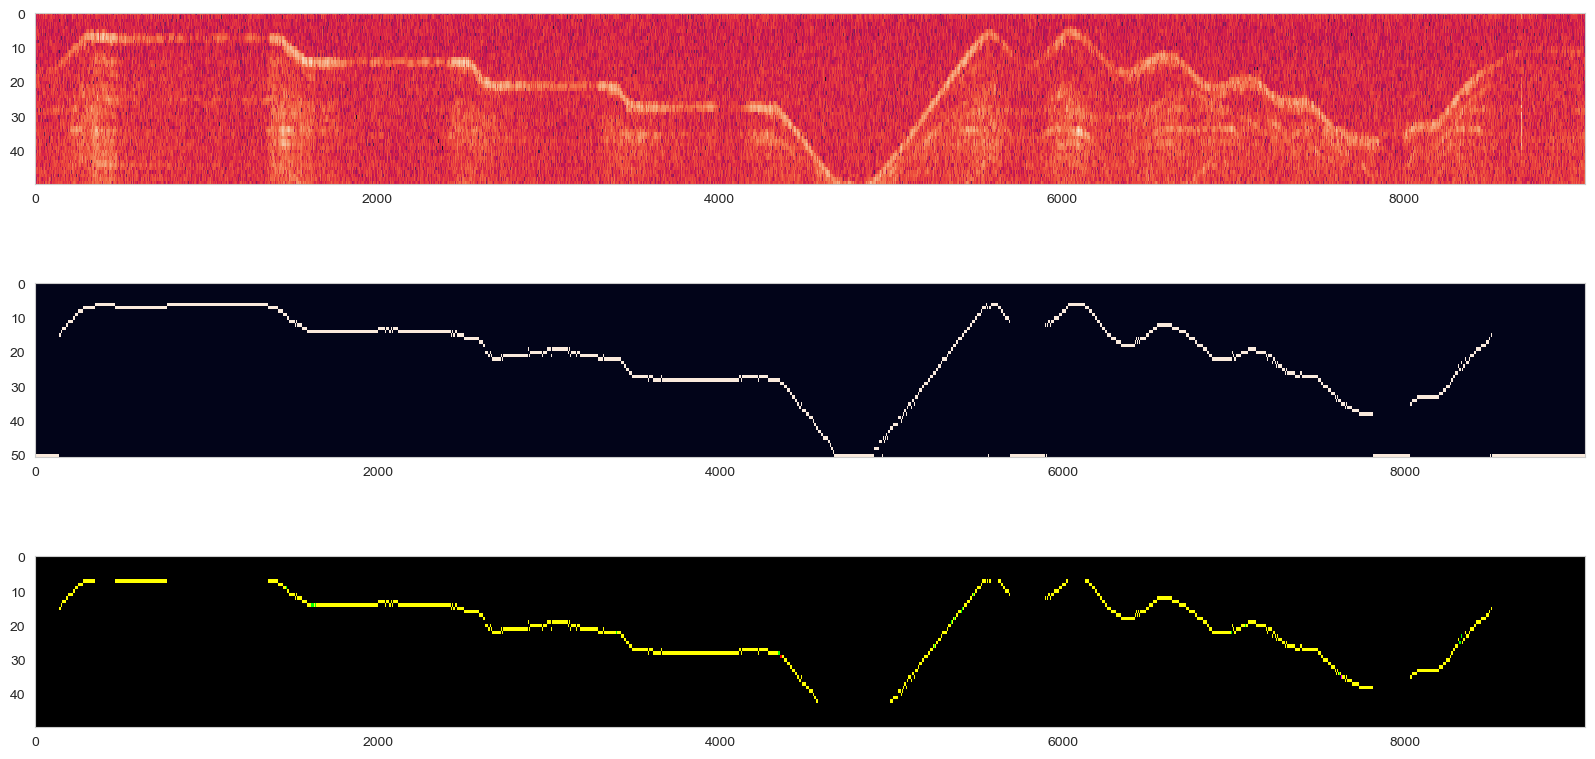

In [32]:
plt.rcParams["figure.figsize"] = (20,10)
aspect = 20
f, axarr = plt.subplots(3,1)
axarr[0].imshow(spects[0], aspect=aspect)
axarr[0].grid(False)
axarr[1].imshow(pred11,  aspect =aspect )
axarr[1].grid(False)

img2 =img.swapaxes(0,1)
axarr[2].imshow(img2, aspect=aspect)
axarr[2].grid(False)

- 0-bartek  red
- 1-kuba    green
- 2-oskar   blue
- 3-rafal   yellow
- 4-inne    pink